[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Please upload your ZIP:


Saving latvian_communist_leaflets_1934-1940.zip to latvian_communist_leaflets_1934-1940.zip
ZIP uploaded: latvian_communist_leaflets_1934-1940.zip
Flattened: moved 0 .txt files to /content/corpus
TXT files found: 266
Parsed 266 leaflets.
Sentences: 13778 | Months: 62


/tmp/ipython-input-1867669175.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_df['month'], rotation=45)


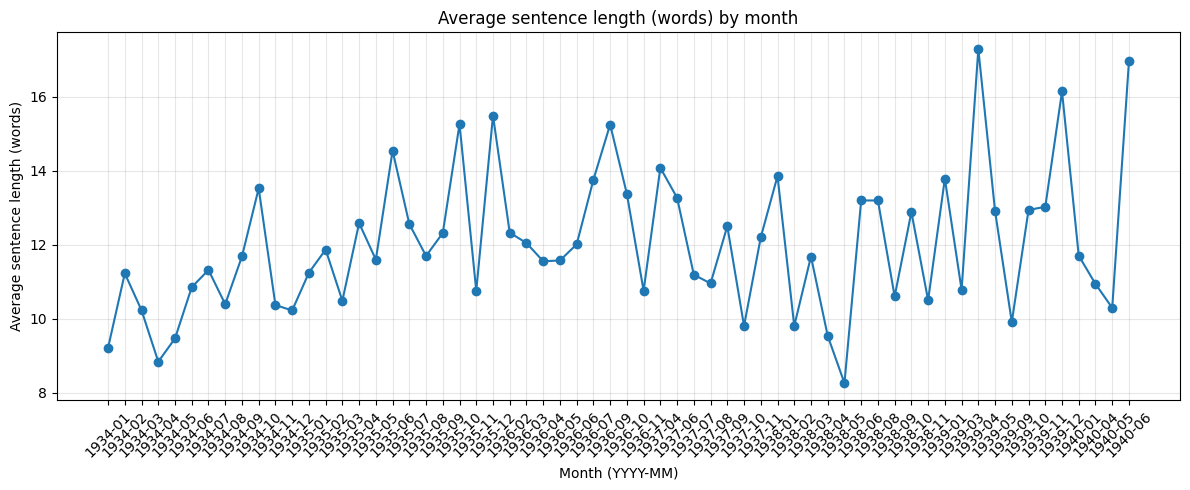

✅ Saved: sentence_word_counts.csv, monthly_avg_sentence_length.csv, monthly_avg_sentence_length.png


In [1]:
# === Latvian Communist Leaflet Corpus: Sentence-length analysis from ZIP upload ===

!pip install --quiet nltk python-dateutil
import nltk, re, os, io, zipfile, glob, shutil
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from dateutil import parser as dateparser
from datetime import datetime
from google.colab import files

nltk.download('punkt')
nltk.download('punkt_tab')

# === 1. Upload ZIP ===
folder_path = '/content/corpus'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
os.makedirs(folder_path, exist_ok=True)

print("Please upload your ZIP:")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("❌ ZIP not uploaded — please try again.")

zip_name = next(iter(uploaded.keys()))
print("ZIP uploaded:", zip_name)

# === 2. Extract ===
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zf:
    zf.extractall(folder_path)

# Flatten (move .txt up if nested)
def flatten_txt(root='/content/corpus'):
    moved = 0
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith('.txt'):
                src = os.path.join(dirpath, fn)
                dst = os.path.join(root, fn)
                if src != dst and not os.path.exists(dst):
                    shutil.move(src, dst)
                    moved += 1
    for dirpath, dirnames, filenames in list(os.walk(root, topdown=False)):
        if dirpath != root and not dirnames and not filenames:
            os.rmdir(dirpath)
    print(f"Flattened: moved {moved} .txt files to {root}")

flatten_txt(folder_path)
txt_files = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(f"TXT files found: {len(txt_files)}")
if not txt_files:
    raise SystemExit("❌ No .txt files found in ZIP!")

# === 3. Parse leaflet files ===
def parse_leaflet_file(path):
    meta = {}
    text_lines, in_text = [], False
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        for raw in f:
            line = raw.rstrip('\n')
            if not in_text:
                m = re.match(r'^(\w+):\s*(.*)$', line)
                if m:
                    key, val = m.group(1).strip().lower(), m.group(2).strip()
                    if key.startswith('text'):
                        in_text = True
                        if val:
                            text_lines.append(val)
                    else:
                        meta[key] = val
            else:
                text_lines.append(line)
    text = "\n".join(text_lines).strip()

    # find date
    date_raw = (meta.get('date') or '').strip()
    if date_raw:
        date_raw = date_raw.strip(' []…')
    else:
        fname = meta.get('file_name') or os.path.basename(path)
        m = re.search(r'(19\d{2}(?:-\d{2}(?:-\d{2})?)?)', fname)
        date_raw = m.group(1) if m else None

    return {
        'file_name': meta.get('file_name') or os.path.basename(path),
        'date_raw': date_raw,
        'text': text
    }

docs = [parse_leaflet_file(p) for p in txt_files]
print(f"Parsed {len(docs)} leaflets.")

# === 4. Sentence split & word count ===
from nltk.tokenize import sent_tokenize

def split_sentences(text):
    parts = re.split(r'(?<=[\.\!\?…])\s+', text.replace('\r', '\n'))
    parts = [p.strip() for p in parts if p and not p.isspace()]
    if len(parts) <= 1:
        parts = sent_tokenize(text)
    return parts

def count_words(sentence):
    s = sentence.strip()
    s = re.sub(r'^[\s\W]+|[\s\W]+$', '', s)
    if not s: return 0
    return len(re.findall(r"[A-Za-zĀ-žĀĒĪŪāēīūĶĻŅŖČĢŠŽčģšž0-9_\-']+", s, flags=re.UNICODE))

def iso_month_from_raw(date_raw):
    if not date_raw: return None
    try:
        dt = dateparser.parse(date_raw, default=datetime(1900,1,1))
        return dt.strftime('%Y-%m')
    except:
        m = re.search(r'(19\d{2})-(\d{2})', date_raw)
        return f"{m.group(1)}-{m.group(2)}" if m else None

# === 5. Analyze ===
rows = []
per_month = defaultdict(list)
for d in docs:
    month = iso_month_from_raw(d.get('date_raw'))
    sents = split_sentences(d.get('text') or '')
    for s in sents:
        c = count_words(s)
        if c > 0:
            rows.append({'file_name': d['file_name'], 'month': month, 'sentence': s, 'words': c})
            if month:
                per_month[month].append(c)

df_sents = pd.DataFrame(rows)
month_df = pd.DataFrame(
    [{'month': m, 'avg_sentence_length': sum(v)/len(v), 'n_sentences': len(v)} for m,v in per_month.items()]
).sort_values('month') if per_month else pd.DataFrame(columns=['month','avg_sentence_length','n_sentences'])

print("Sentences:", len(df_sents), "| Months:", len(month_df))

# === 6 Plot ===
if month_df.empty:
    print("⚠️ No monthly data (maybe missing dates?).")
else:
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(month_df['month'], month_df['avg_sentence_length'], marker='o')
    ax.set_xticklabels(month_df['month'], rotation=45)
    ax.set_xlabel('Month (YYYY-MM)')
    ax.set_ylabel('Average sentence length (words)')
    ax.set_title('Average sentence length (words) by month')
    ax.grid(alpha=0.3)
    fig.tight_layout()
    fig.savefig('monthly_avg_sentence_length.png', dpi=200)  # save PNG
    plt.show()
    plt.close(fig)

df_sents.to_csv('sentence_word_counts.csv', index=False)
month_df.to_csv('monthly_avg_sentence_length.csv', index=False)
print("✅ Saved: sentence_word_counts.csv, monthly_avg_sentence_length.csv, monthly_avg_sentence_length.png")


=== Sentences per leaflet by month ===
      month  avg_sentences_per_leaflet  total_sentences  n_leaflets
0   1934-01                  63.500000              508           8
1   1934-02                  72.625000              581           8
2   1934-03                  60.428571              423           7
3   1934-04                  57.000000              570          10
4   1934-05                  51.857143              363           7
..      ...                        ...              ...         ...
57  1939-12                  29.000000               29           1
58  1940-01                  37.000000               37           1
59  1940-04                  57.500000              115           2
60  1940-05                  43.000000              129           3
61  1940-06                  22.000000               22           1

[62 rows x 4 columns]


/tmp/ipython-input-3149638465.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_sent['month'], rotation=45)


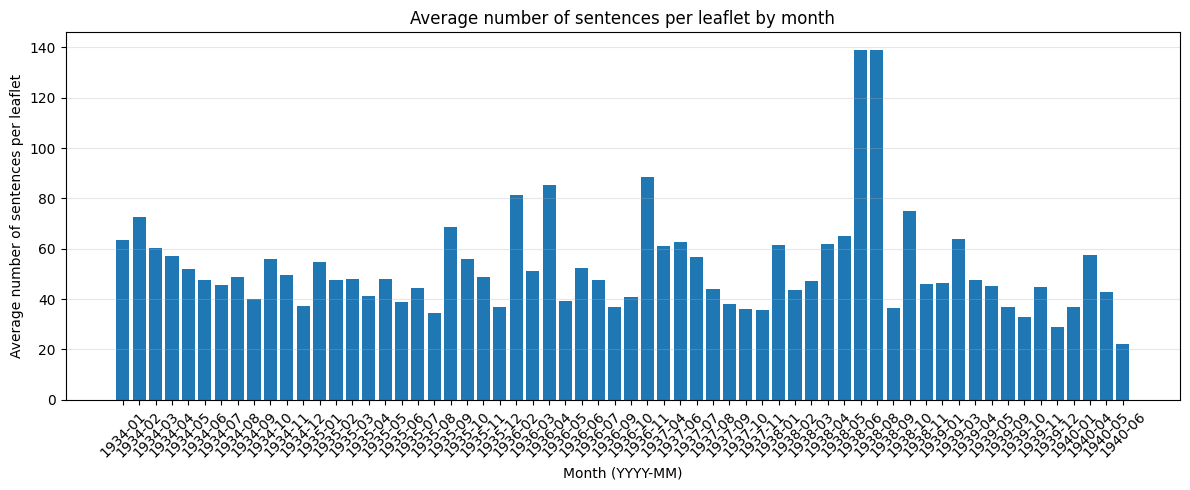

✅ Saved: monthly_avg_sentences_per_leaflet.csv, monthly_avg_sentences_per_leaflet.png


In [2]:
# === 5a. Average number of sentences per leaflet by month ===

if not df_sents.empty:
    # 1) Teikumu skaits katrā skrejlapā katrā mēnesī
    sent_counts = (
        df_sents
        .dropna(subset=['month'])                    # izmetam bez datuma
        .groupby(['month', 'file_name'])
        .size()
        .reset_index(name='n_sentences_leaflet')     # teikumu skaits vienā skrejlapā
    )

    # 2) Statistika pa mēnešiem:
    #    - vidējais teikumu skaits vienā skrejlapā
    #    - kopējais teikumu skaits mēnesī
    #    - skrejlapu skaits mēnesī
    month_sent = (
        sent_counts
        .groupby('month')['n_sentences_leaflet']
        .agg(
            avg_sentences_per_leaflet='mean',
            total_sentences='sum',
            n_leaflets='count'
        )
        .reset_index()
        .sort_values('month')
    )

    print("\n=== Sentences per leaflet by month ===")
    print(month_sent)

    # 3) Grafiks: vidējais teikumu skaits vienā skrejlapā pa mēnešiem
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(month_sent['month'], month_sent['avg_sentences_per_leaflet'])
    ax.set_xticklabels(month_sent['month'], rotation=45)
    ax.set_xlabel('Month (YYYY-MM)')
    ax.set_ylabel('Average number of sentences per leaflet')
    ax.set_title('Average number of sentences per leaflet by month')
    ax.grid(axis='y', alpha=0.3)
    fig.tight_layout()
    fig.savefig('monthly_avg_sentences_per_leaflet.png', dpi=200)
    plt.show()
    plt.close(fig)

    # 4) Saglabāšana
    month_sent.to_csv('monthly_avg_sentences_per_leaflet.csv', index=False)
    print("✅ Saved: monthly_avg_sentences_per_leaflet.csv, monthly_avg_sentences_per_leaflet.png")
else:
    print("⚠️ No sentence data to compute monthly averages.")



=== Words per leaflet by month ===
      month  avg_words_per_leaflet  total_words  n_leaflets
0   1934-01             585.250000         4682           8
1   1934-02             815.250000         6522           8
2   1934-03             618.000000         4326           7
3   1934-04             503.900000         5039          10
4   1934-05             491.000000         3437           7
..      ...                    ...          ...         ...
57  1939-12             468.000000          468           1
58  1940-01             433.000000          433           1
59  1940-04             629.000000         1258           2
60  1940-05             442.666667         1328           3
61  1940-06             373.000000          373           1

[62 rows x 4 columns]


/tmp/ipython-input-12782571.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_words['month'], rotation=45)


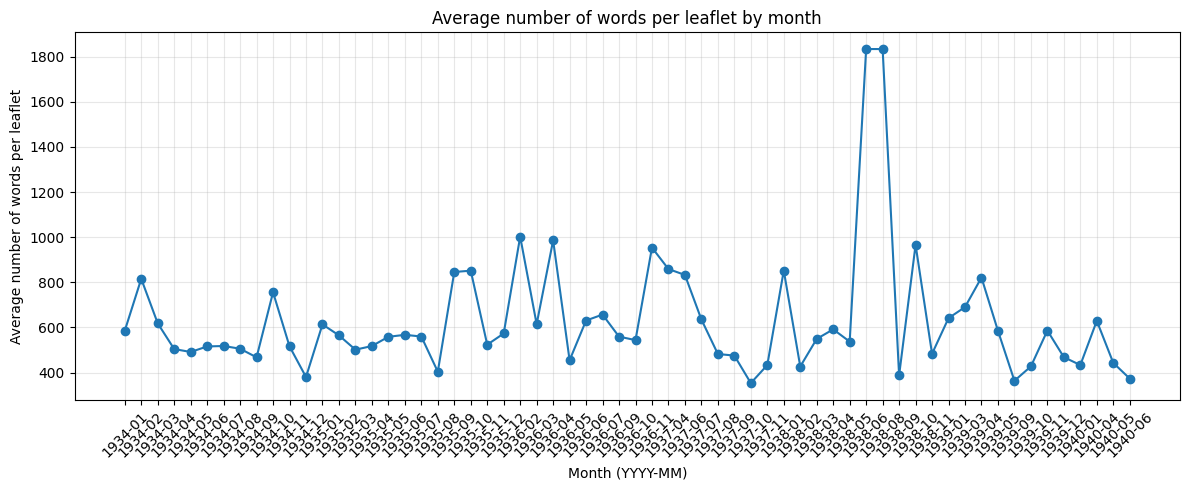

✅ Saved: monthly_avg_words_per_leaflet.csv, monthly_avg_words_per_leaflet.png


In [3]:
# === 5b. Average number of words per leaflet by month ===

if not df_sents.empty:
    # 1) Words per leaflet per month
    # df_sents already has column 'words'
    words_per_leaflet = (
        df_sents
        .dropna(subset=['month'])               # drop rows without month
        .groupby(['month', 'file_name'])['words']
        .sum()                                  # total words in each leaflet
        .reset_index(name='total_words_leaflet')
    )

    # 2) Monthly statistics
    month_words = (
        words_per_leaflet
        .groupby('month')['total_words_leaflet']
        .agg(
            avg_words_per_leaflet='mean',       # average words per leaflet
            total_words='sum',                  # all words in month
            n_leaflets='count'                  # leaflet count
        )
        .reset_index()
        .sort_values('month')
    )

    print("\n=== Words per leaflet by month ===")
    print(month_words)

    # 3) Plot: average words per leaflet by month
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(month_words['month'], month_words['avg_words_per_leaflet'], marker='o')
    ax.set_xticklabels(month_words['month'], rotation=45)
    ax.set_xlabel('Month (YYYY-MM)')
    ax.set_ylabel('Average number of words per leaflet')
    ax.set_title('Average number of words per leaflet by month')
    ax.grid(alpha=0.3)
    fig.tight_layout()
    fig.savefig('monthly_avg_words_per_leaflet.png', dpi=200)
    plt.show()
    plt.close(fig)

    # 4) Save CSV
    month_words.to_csv('monthly_avg_words_per_leaflet.csv', index=False)
    print("✅ Saved: monthly_avg_words_per_leaflet.csv, monthly_avg_words_per_leaflet.png")

else:
    print("⚠️ No sentence/word data — cannot compute monthly averages.")


In [4]:
# === GLOBAL STATISTICS (all years combined) ===

from statistics import median, mode, mean

global_words = df_sents['words'].dropna().tolist()

global_stats = {
    'mean_words': mean(global_words),
    'median_words': median(global_words),
    'mode_words': mode(global_words)
}

print("\n=== GLOBAL WORD STATISTICS (per sentence) ===")
print(global_stats)



=== GLOBAL WORD STATISTICS (per sentence) ===
{'mean_words': 11.551676585861518, 'median_words': 9.0, 'mode_words': 4}


In [5]:
# === MONTHLY STATISTICS (per sentence) ===

monthly_stats = (
    df_sents
    .dropna(subset=['month'])
    .groupby('month')['words']
    .agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None])
    .rename(columns={'<lambda_0>': 'mode'})
    .reset_index()
    .sort_values('month')
)

print("\n=== MONTHLY WORD STATISTICS (per sentence) ===")
print(monthly_stats)



=== MONTHLY WORD STATISTICS (per sentence) ===
      month       mean  median  mode
0   1934-01   9.216535     7.0     1
1   1934-02  11.225473     9.0     4
2   1934-03  10.226950     8.0     1
3   1934-04   8.840351     6.0     4
4   1934-05   9.468320     8.0     4
..      ...        ...     ...   ...
57  1939-12  16.137931    16.0    16
58  1940-01  11.702703     9.0     9
59  1940-04  10.939130    11.0     1
60  1940-05  10.294574     8.0     5
61  1940-06  16.954545    13.5    10

[62 rows x 4 columns]


In [6]:
df_sents['year'] = df_sents['month'].str.slice(0,4)

# === YEARLY STATISTICS (per sentence) ===

yearly_stats = (
    df_sents
    .dropna(subset=['year'])
    .groupby('year')['words']
    .agg(['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None])
    .rename(columns={'<lambda_0>': 'mode'})
    .reset_index()
    .sort_values('year')
)

print("\n=== YEARLY WORD STATISTICS (per sentence) ===")
print(yearly_stats)



=== YEARLY WORD STATISTICS (per sentence) ===
   year       mean  median  mode
0  1934  10.624029     8.0     4
1  1935  12.037088     9.0     4
2  1936  12.171505    10.0     4
3  1937  12.193111     9.0     4
4  1938  11.538776    10.0     1
5  1939  12.792129    10.0     4
6  1940  11.194719    10.0     5


In [7]:
from statistics import mean, median, mode

# === 1. Teikumu skaits vienā skrejlapā (per leaflet) ===

if df_sents.empty:
    raise SystemExit("❌ df_sents is empty – nothing to analyze.")

# выкидываем листовки без месяца, если месяц нужен
sent_counts = (
    df_sents
    .dropna(subset=['month'])
    .groupby(['month', 'file_name'])
    .size()
    .reset_index(name='n_sentences_leaflet')   # teikumu skaits vienā skrejlapā
)

# добавим год
sent_counts['year'] = sent_counts['month'].str.slice(0, 4)


In [9]:
# === 2. GLOBAL stats: sentences per leaflet (all years together) ===

vals = sent_counts['n_sentences_leaflet'].tolist()

global_leaflet_stats = {
    'mean_sentences_per_leaflet': mean(vals),
    'median_sentences_per_leaflet': median(vals),
    'mode_sentences_per_leaflet': mode(vals)
}

print("\n=== GLOBAL: sentences per leaflet (all years) ===")
print(global_leaflet_stats)



=== GLOBAL: sentences per leaflet (all years) ===
{'mean_sentences_per_leaflet': 51.99245283018868, 'median_sentences_per_leaflet': 47, 'mode_sentences_per_leaflet': 50}


In [10]:
# === 3. MONTHLY stats: sentences per leaflet ===

def first_mode(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else None

monthly_leaflet_stats = (
    sent_counts
    .groupby('month')['n_sentences_leaflet']
    .agg(
        mean_sentences_per_leaflet='mean',
        median_sentences_per_leaflet='median',
        mode_sentences_per_leaflet=first_mode,
        n_leaflets='count'
    )
    .reset_index()
    .sort_values('month')
)

print("\n=== MONTHLY: sentences per leaflet ===")
print(monthly_leaflet_stats.head())

# если нужно, сохрани:
monthly_leaflet_stats.to_csv("monthly_sentences_per_leaflet_stats.csv", index=False)



=== MONTHLY: sentences per leaflet ===
     month  mean_sentences_per_leaflet  median_sentences_per_leaflet  \
0  1934-01                   63.500000                          67.0   
1  1934-02                   72.625000                          71.5   
2  1934-03                   60.428571                          59.0   
3  1934-04                   57.000000                          46.0   
4  1934-05                   51.857143                          55.0   

   mode_sentences_per_leaflet  n_leaflets  
0                          49           8  
1                          49           8  
2                          22           7  
3                          31          10  
4                          28           7  


In [11]:
# === 4. YEARLY stats: sentences per leaflet ===

yearly_leaflet_stats = (
    sent_counts
    .dropna(subset=['year'])
    .groupby('year')['n_sentences_leaflet']
    .agg(
        mean_sentences_per_leaflet='mean',
        median_sentences_per_leaflet='median',
        mode_sentences_per_leaflet=first_mode,
        n_leaflets='count'
    )
    .reset_index()
    .sort_values('year')
)

print("\n=== YEARLY: sentences per leaflet ===")
print(yearly_leaflet_stats)

yearly_leaflet_stats.to_csv("yearly_sentences_per_leaflet_stats.csv", index=False)



=== YEARLY: sentences per leaflet ===
   year  mean_sentences_per_leaflet  median_sentences_per_leaflet  \
0  1934                   52.831579                          49.0   
1  1935                   48.250000                          46.0   
2  1936                   60.000000                          55.0   
3  1937                   50.421053                          49.0   
4  1938                   65.333333                          47.0   
5  1939                   45.045455                          44.5   
6  1940                   43.285714                          48.0   

   mode_sentences_per_leaflet  n_leaflets  
0                          31          95  
1                          32          76  
2                          43          31  
3                          19          19  
4                          38          15  
5                          50          22  
6                          48           7  
